In [109]:
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL


# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

# Nixlaverse model utilities
from hierarchicalforecast.core import HierarchicalReconciliation
# from hierarchicalforecast.evaluation import evaluate
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss, mape
from statsforecast.models import AutoETS
from statsforecast import StatsForecast



# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)


Reading clean dataset


In [110]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Entry route codes

In [111]:
arrivals_dataset.entry_route_table

,entry_route,entry_route_id
0,terrestre,2
1,fluvial,4
2,aereo,1
3,maritimo,3


Continent codes

In [112]:
arrivals_dataset.continent_table

,continent,continent_id
0,africa,1
1,america_central_e_caribe,2
2,america_do_norte,3
3,america_do_sul,4
4,asia,5
5,europa,6
6,oceania,7
7,continente_nao_especificado,8


In [113]:
df

,continent,continent_id,country,country_id,state,state_id,entry_route,entry_route_id,year,month,month_id,arrivals,file_index,date
0,africa,1,africa_do_sul,2,acre,1,terrestre,2,2015,janeiro,1,2.0,file_0,2015-01-01
1,africa,1,angola,6,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
2,africa,1,cabo_verde,35,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
3,africa,1,egito,60,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
4,africa,1,gana,77,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762567,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,agosto,8,0.0,file_24,2018-08-01
762568,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,setembro,9,0.0,file_24,2018-09-01
762569,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,outubro,10,0.0,file_24,2018-10-01
762570,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,novembro,11,0.0,file_24,2018-11-01


## Total arrivals prediction

In [114]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)

df_rj.tail()

,date,arrivals
295,2024-08-01,91504.0
296,2024-09-01,116003.0
297,2024-10-01,130985.0
298,2024-11-01,145148.0
299,2024-12-01,176121.0


### First try: damped trend ETS model for post-covid years. 

Create unique id column and guarantee that time series is sorted.

In [ ]:
df_ets = df_rj.copy()
df_ets["unique_id"] = "rj"
df_ets = df_ets[["unique_id", "date", "arrivals"]].sort_values(["unique_id", "date"])
df_ets = df_ets.query("date >= '2022-01-01'") # Only post covid data
df_ets = df_ets.rename(columns={"date":"ds", "arrivals":"y"})
df_ets.tail()

,unique_id,ds,y
295,rj,2024-08-01,91504.0
296,rj,2024-09-01,116003.0
297,rj,2024-10-01,130985.0
298,rj,2024-11-01,145148.0
299,rj,2024-12-01,176121.0


In [116]:
# AutoETS config
FREQ = "MS"
SEASON_LENGTH = 12   # sazonalidade mensal

# Cross validation configs
H = 12
STEP = 6
N_WINDOWS = 3

Create AutoETS instance:  Since, from the EDA, we know that 2022 was still an atypical year, with strong positive trend, and afterwards things start to be as usual, we'll consider a damped additive trend, that should mimic the described time series behaviour.

In [117]:
autoets = AutoETS(season_length=SEASON_LENGTH, damped=True)

Fitting ETS and performing cross validation

In [118]:
sf = StatsForecast(models=[autoets], freq=FREQ, n_jobs=-1)
cv_df = sf.cross_validation(
    df=df_ets,
    h=H,
    step_size=STEP,
    n_windows=N_WINDOWS,
)

Changing predictions column to y_hat

In [119]:
pred_col = autoets.alias  # normalmente "AutoETS"
cv_eval = cv_df.rename(columns={pred_col: "y_hat"})
cv_eval.head()

,unique_id,ds,cutoff,y,y_hat
0,rj,2023-01-01,2022-12-01,136256.0,95518.573969
1,rj,2023-02-01,2022-12-01,137200.0,99092.143041
2,rj,2023-03-01,2022-12-01,128797.0,102594.240732
3,rj,2023-04-01,2022-12-01,80984.0,106026.296469
4,rj,2023-05-01,2022-12-01,65886.0,109389.711091


In [120]:
metrics_overall = evaluate(
    df=cv_df,
    metrics=[smape, rmse, mae, mape],
    models=[pred_col],
    agg_fn="mean",          # média das perdas ao longo das linhas
    id_col="unique_id",
    time_col="ds",
    target_col="y",
)

Calculating cross validation error metrics.

In [121]:
metrics_overall

,metric,AutoETS
0,smape,0.177445
1,rmse,46031.865643
2,mae,39228.129510
3,mape,0.370888


In [ ]:
sf_final = sf.fit(df_ets)
fcst = sf_final.forecast(df=df_ets, h=H, level=[80, 95])

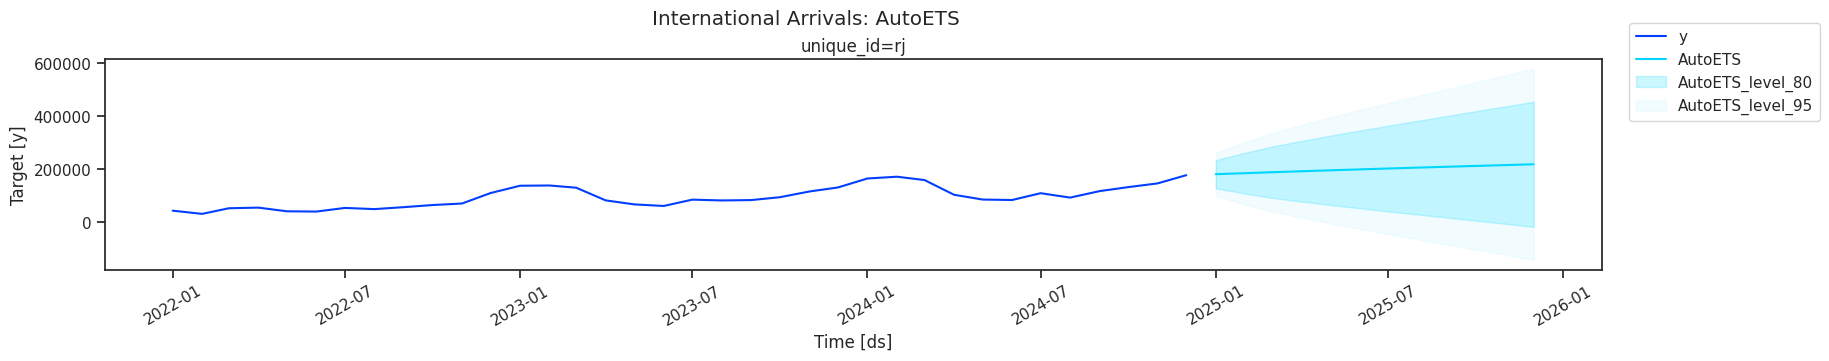

In [ ]:
fig = plot_series(
    df_ets,
    fcst,
    level=[80, 95],
    models=[autoets.alias],
)

fig.suptitle("International Arrivals: AutoETS")
fig


Those predictions are clearly a joke, since we're only training the model with 24 months, and trying to predict 12 months with the ETS model.

In [159]:
autoets = AutoETS(season_length=12, damped=True, model="ZZZ")
autoets = autoets.fit(y=df_ets["y"].values)

Adjusting AutoETS to the whole time series returns a model without seasonality, which doesn't make sense. 

In [169]:
autoets.model_["method"]

'ETS(M,Ad,N)'

TODO: AutoARIMA

In [134]:
dir(autoets)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_conformal_intervals',
 '_add_predict_conformal_intervals',
 '_conformal_method',
 '_conformity_scores',
 '_store_cs',
 'alias',
 'damped',
 'fit',
 'forecast',
 'forward',
 'model',
 'new',
 'phi',
 'predict',
 'predict_in_sample',
 'prediction_intervals',
 'season_length',
 'uses_exog']

In [150]:
sf_final.models[0].model_

AttributeError: 'AutoETS' object has no attribute 'model_'